In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
import os

from warnings import filterwarnings
filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
#load the data
data = pd.read_csv('D:\\Study\\DataScience\\Data\\MachineLearningData\\TrafficData\\ahdt.csv')

In [3]:
#df = data[(data['plaza_id'] == '30') & (data['direction'] == 'I') ]
df = data[(data['plaza_id'] == 25) & (data['direction'] == 'I')]

In [4]:
df['total'] = df['vehicles_etc_e_zpass'] + df['vehicles_cash_vtoll']

In [5]:
df['date'] =  pd.to_datetime(df['date'])

In [6]:
df.tail()

,plaza_id,date,hour,direction,vehicles_etc_e_zpass,vehicles_cash_vtoll,total
198627,25,2017-09-03,19,I,383,59,442
198629,25,2017-09-03,20,I,382,35,417
198631,25,2017-09-03,21,I,304,41,345
198633,25,2017-09-03,22,I,250,26,276
198635,25,2017-09-03,23,I,196,22,218


In [7]:
# sort Date and Hour - descending order
df.sort_values(by=['date', 'hour'], inplace=True, ascending=[True, True])

In [8]:
df['drange'] = pd.date_range(start ='2019-01-01 00:00:00', periods = len(df), freq='H') 

In [9]:
df.tail()

,plaza_id,date,hour,direction,vehicles_etc_e_zpass,vehicles_cash_vtoll,total,drange
182,25,2019-03-02,19,I,415,42,457,2020-04-19 21:00:00
184,25,2019-03-02,20,I,327,36,363,2020-04-19 22:00:00
186,25,2019-03-02,21,I,292,38,330,2020-04-19 23:00:00
188,25,2019-03-02,22,I,263,28,291,2020-04-20 00:00:00
190,25,2019-03-02,23,I,245,21,266,2020-04-20 01:00:00


In [10]:
# Drop unnecessory columns ['plaza_id', 'date', 'hour', 'direction', 'vehicles_etc_e_zpass', 'vehicles_cash_vtoll']
df = df.drop(columns =['plaza_id', 'date', 'hour', 'direction', 'vehicles_etc_e_zpass', 'vehicles_cash_vtoll']) 

In [11]:
# set drange column as index
df = df.set_index('drange')
df.index = pd.to_datetime(df.index)

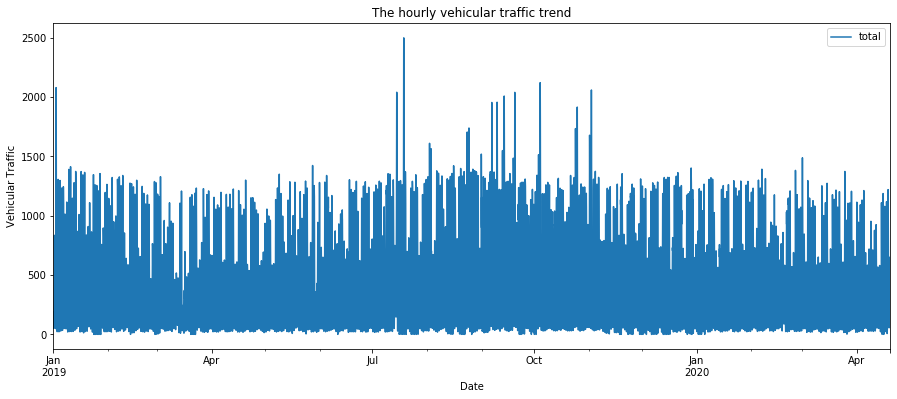

In [12]:
# Plot the dataframe to visualize time series data
df.plot(figsize=(15, 6))
plt.xlabel('Date')
plt.ylabel('Vehicular Traffic')
plt.title('The hourly vehicular traffic trend')
plt.show()

In [13]:
# Convert dataframe into Numpy array
data_copy = df.copy()
df = df.values

In [14]:
# Perform feature scaling of data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Divide data into 80% training and 20% testing
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

In [15]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30

X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [17]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=50, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 9090 samples, validate on 2250 samples
Epoch 1/50
9090/9090 [==============================] - 1s 112us/step - loss: 0.0089 - val_loss: 0.0029
Epoch 2/50
9090/9090 [==============================] - 1s 66us/step - loss: 0.0038 - val_loss: 0.0021
Epoch 3/50
9090/9090 [==============================] - 1s 76us/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/50
9090/9090 [==============================] - 0s 46us/step - loss: 0.0024 - val_loss: 0.0015
Epoch 5/50
9090/9090 [==============================] - 0s 48us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/50
9090/9090 [==============================] - 0s 46us/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
9090/9090 [==============================] - 0s 45us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/50
9090/9090 [==============================] - 0s 49us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/50
9090/9090 [==============================] - 0s 46us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/50
9090/9090 [=

In [19]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error: {:.4f}'.format(mean_absolute_error(Y_train[0], train_predict[:,0])))
print('Train Root Mean Squared Error: {:.4f}'.format(np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))))
print('Test Mean Absolute Error: {:.4f}'.format(mean_absolute_error(Y_test[0], test_predict[:,0])))
print('Test Root Mean Squared Error: {:.4f}'.format(np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))))

Train Mean Absolute Error: 62.1481
Train Root Mean Squared Error: 88.6350
Test Mean Absolute Error: 52.6061
Test Root Mean Squared Error: 74.5572


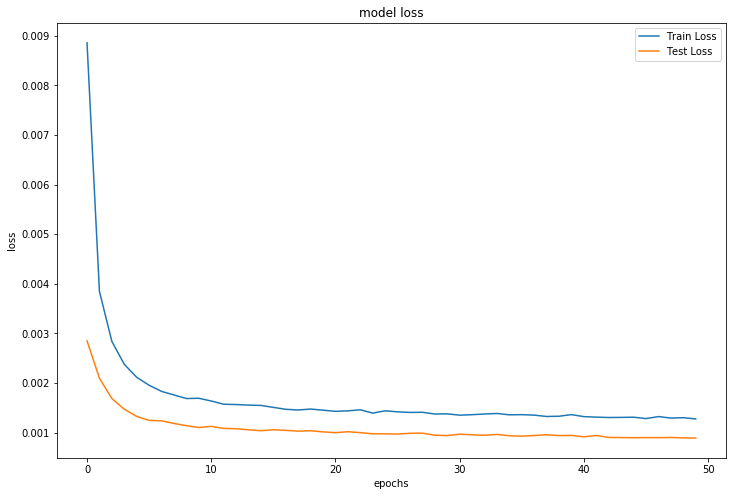

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

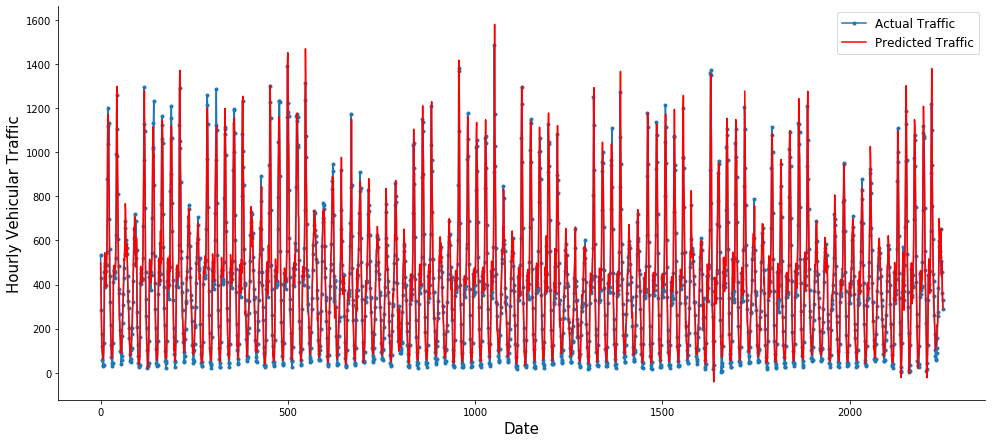

In [21]:
ax = [x for x in range(len(test_predict))]
plt.figure(figsize = (14,6))
plt.plot(ax, Y_test[0][:len(test_predict)], marker='.', label='Actual Traffic')
plt.plot(ax, test_predict[:,0][:len(test_predict)], 'r', label='Predicted Traffic')
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Hourly Vehicular Traffic', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=12)
plt.show()

In [27]:
# Create a blank dataframe with date range same as X_test
drange_predict = pd.date_range(end ='2020-04-20 01:00:00', periods = len(X_test), freq='H') 

In [30]:
df_predict = pd.DataFrame(index=drange_predict, data=test_predict)

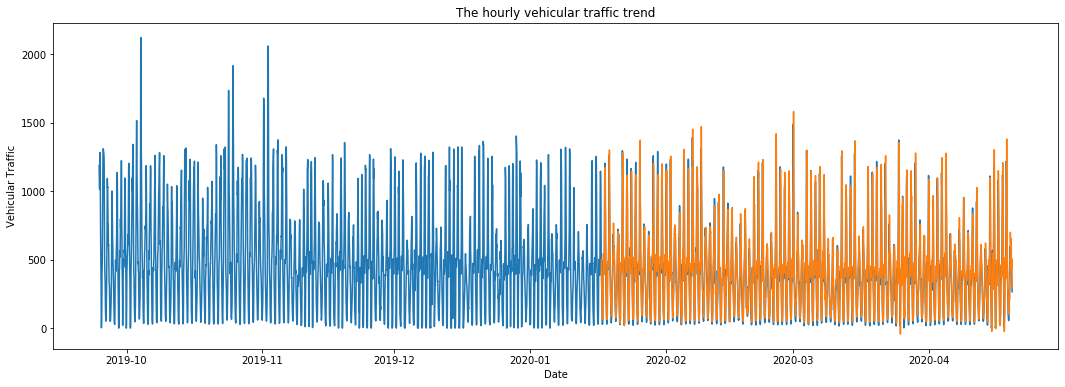

In [41]:
# Plot the dataframe to visualize time series data
plt.figure(figsize=(18,6))
plt.plot(data_copy.iloc[-5000:])
plt.plot(df_predict)
plt.xlabel('Date')
plt.ylabel('Vehicular Traffic')
plt.title('The hourly vehicular traffic trend')
plt.show()